### Dimensionality Reduction Comparison
#### Clustering Metric
The goal of this notebook is to come up with a metric that uses clustering at different levels of dimensionality to determine "nearby" interactions between cells and score transformed data based on the degree to which those distances are preserved in relation to un-reduced data.

In [12]:
import fcc_utils

import numpy as np
import scipy as sc

# package for reading in data files
import h5py

# scikit packages
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# import tsne packages
from sklearn.manifold import TSNE

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')
%matplotlib inline

In [4]:
# read in an example dataset from Bob
AS1_1291 = tSNE_utils.read_hdf5('inputs/Adj-Norm-1291-AS1.h5')

In [6]:
AS1_1291.keys()

dict_keys(['counts_0', 'transcripts_0'])

In [11]:
print('Counts shape: {}\nTranscript labels shape: {}\n'.format(AS1_1291['counts_0'].shape, AS1_1291['transcripts_0'].shape))

Counts shape: (17590, 38254)
Transcript labels shape: (38254,)



So this data is of shape *(n_cells, n_genes)*, and the genes are labeled nicely for us in the `AS1_1291['transcripts_0']` vector.

In [20]:
# let's take a subset of this data so it isn't too computationally expensive
AS1_1291_1 = AS1_1291['counts_0'][np.random.choice(AS1_1291['counts_0'].shape[0], 500)]

AS1_1291_1.shape # confirm it's the right size (500, 32854)

(500, 38254)

In [21]:
# normalize counts data using arcsinh transformation
AS1_1291_1_norm = fcc_utils.arcsinh_norm(AS1_1291_1, norm=True, scale=1000)

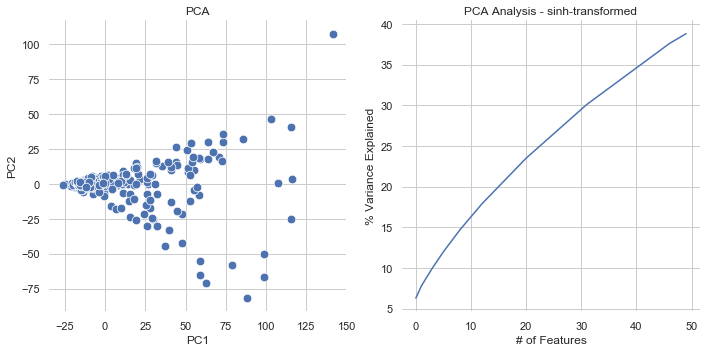

In [22]:
# Perform PCA on subsample of 500 cells with 50 components
PCA_fit = PCA(n_components=50).fit(AS1_1291_1_norm)
# transform data to fit
PCA_results = PCA_fit.transform(AS1_1291_1_norm)

# Plot PCA
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(PCA_results[:,0], PCA_results[:,1], s=75)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

plt.subplot(122)
plt.plot(np.cumsum(np.round(PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

sns.despine(left=True, bottom=True)
plt.tight_layout()